  <style>
    .container {
      display: flex;
      justify-content: space-between;
      align-items: center;
    }

    .text {
      width: 95%;
       text-align: center;
    }

    .image {
      width: 5%;
      text-align: center; 
    }

    
    .image img {
      max-width: 100%;
      height: auto;
    }
  </style> 
  
  <div class="container">
    <div class="image">
      <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Logo_KIT.svg/1200px-Logo_KIT.svg.png" width=100 height=50/>
    </div>
        <div class="text">
      <h1> Medical Image Processing and Navigation 2024/25</h1>
    </div>
  </div>


---

<center>
<h2>Multi Atlas Based Segmentation (MABS)</h2> 
<center><img src="https://d3i71xaburhd42.cloudfront.net/6fb13081e034b919f52b30a1b953328349c0c877/2-Figure1-1.png"></center>

---

<center>
Lecturer: <b><i>Ciro Benito Raggio</i></b> 
<br/>
<a><href>https://www.ibt.kit.edu/english/Raggio_C.php</href></a>

Atlas-based segmentation exploits knowledge from previously labeled training images to segment the target image. 

Multi-atlas segmentation methods map all labeled images onto the target image, which helps to reduce segmentation errors.

In [1]:
import numpy as np
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [2]:
def bin_img(img):
    img = img.astype(np.float32)
    img -= img.min()
    img /= img.max()
    return img.astype(np.uint8)

## Choose the structure to segment

In [4]:
import os

# Mutlak yol
path = r'C:\Users\User\Desktop\Master_Dersleri\Medical Image Processing for Navigation and Guidence\Data\MABS\patient'

In [3]:
print(f"Structures available: {os.listdir('./assets/data/MABS/patient/')}")

FileNotFoundError: [WinError 3] Sistem belirtilen yolu bulamıyor: './assets/data/MABS/patient/'

In [5]:
structure = "mandible"
selected_slice = 70

Start by reading the patient's CT and reference frame

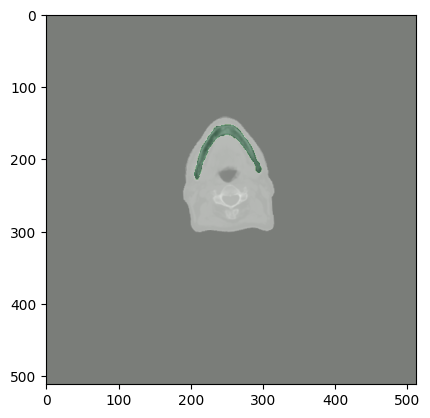

In [10]:
# CT dosyasını oku
ct_sikt = sitk.ReadImage(r"C:\Users\User\Desktop\Master_Dersleri\Medical Image Processing for Navigation and Guidence\Data\MABS\patient\CT.nrrd")
ct = sitk.GetArrayFromImage(ct_sikt)

# Structure dosyasını oku
structure_path = rf"C:\Users\User\Desktop\Master_Dersleri\Medical Image Processing for Navigation and Guidence\Data\MABS\patient\{structure}.nrrd"
structure_sitk = sitk.ReadImage(structure_path)

# İkili görüntü oluştur
structure_bin = bin_img(sitk.GetArrayFromImage(structure_sitk))

# Görüntüle
plt.imshow(ct[selected_slice, :, :], cmap="gray")
plt.imshow(structure_bin[selected_slice, :, :], cmap="Greens", alpha=0.5)
plt.show()


In [ ]:
ct_sikt = sitk.ReadImage(r"C:\Users\User\Desktop\Master_Dersleri\Medical Image Processing for Navigation and Guidence\Data\MABS\patient\CT.nrrd")
ct = sitk.GetArrayFromImage(ct_sikt)

structure_sitk = sitk.ReadImage(r"C:\Users\User\Desktop\Master_Dersleri\Medical Image Processing for Navigation and Guidence\Data\MABS\patient\{structure}.nrrd")
structure_bin = bin_img(sitk.GetArrayFromImage(structure_sitk))

plt.imshow(ct[selected_slice, :, :], cmap="gray")
plt.imshow(structure_bin[selected_slice, :, :], cmap="Greens", alpha=0.5)

## Step 1 - Load the structures of interest from the atlases available

In [13]:
import os
import SimpleITK as sitk

deformed_structs = []
deformed_sitk_structs = []

# Atlasların bulunduğu ana dizin
atlases_path = r"C:\Users\User\Desktop\Master_Dersleri\Medical Image Processing for Navigation and Guidence\Data\MABS"

# Belirli bir yapı adı (örneğin, 'mandible')
structure = "mandible"

# Atlases'i filtrele
atlases = list(filter(lambda dirname: "atl" in dirname, os.listdir(atlases_path)))
print(f"Found {len(atlases)} atlases!\nAtlases' names: {atlases}")

for atlas_index in range(1, len(atlases)+1):
    def_stru_sitk = sitk.ReadImage(
        os.path.join(atlases_path, f"atl{atlas_index}", f"{structure}.nrrd")
    )
    deformed_sitk_structs.append(def_stru_sitk)
    def_stru = bin_img(sitk.GetArrayFromImage(def_stru_sitk))
    deformed_structs.append(def_stru)

print(f"Found {len(deformed_structs)} deformed structures!")


Found 6 atlases!
Atlases' names: ['atl1', 'atl2', 'atl3', 'atl4', 'atl5', 'atl6']
Found 6 deformed structures!


Let's see what structures are loaded by the atlases

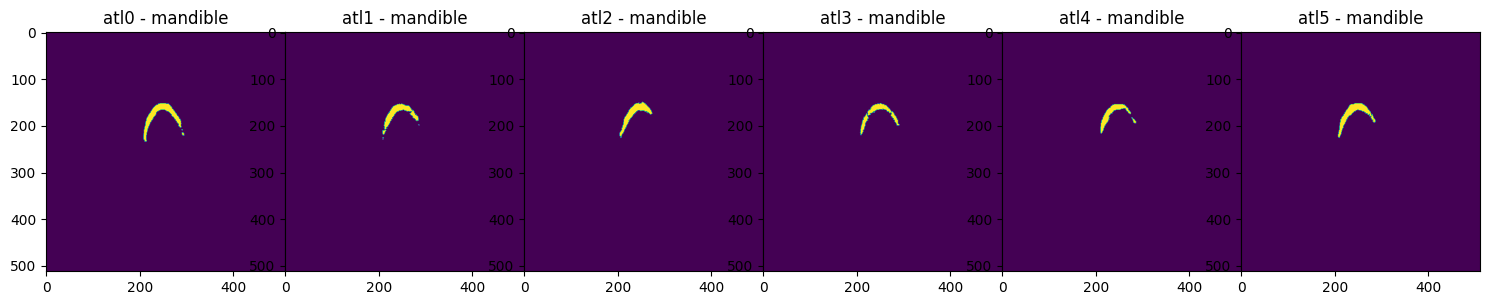

In [14]:
f, axarr = plt.subplots(1, len(deformed_structs), figsize=(15, 10))

for i, deformed_struct in enumerate(deformed_structs):
    img = axarr[i].imshow(deformed_struct[selected_slice, :, :])
    axarr[i].set_title(f"atl{i} - {structure}")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

## Step 2 - Majority voting

<center><img src="https://1.bp.blogspot.com/-wnwx3mulVkU/YKo9a7ocMqI/AAAAAAAACZQ/h8lBb3BNFr8ZN0rNHkpYV6pZfoFk-ugzwCLcBGAsYHQ/s760/Majority.png" /></center>

To perform majority voting, we will iterate over all the deformed structures, accumulating votes for each voxel.

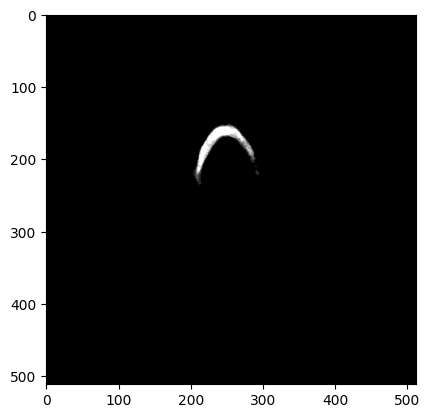

In [15]:
voted_structs = np.zeros_like(structure_bin)
for def_stru in deformed_structs:
    voted_structs += def_stru

plt.imshow(voted_structs[selected_slice, :, :], cmap="gray")

At this point a strategy could be to understand what the maximum votes are for a voxel, which in our case corresponds to the total number of deformed structures available

In [16]:
voted_structs.max()

np.uint8(6)

Knowing that, in this case, a voxel can have been voted on a maximum of 6 times, we can choose to form the final mask only from the voxels that have been voted on at least N times

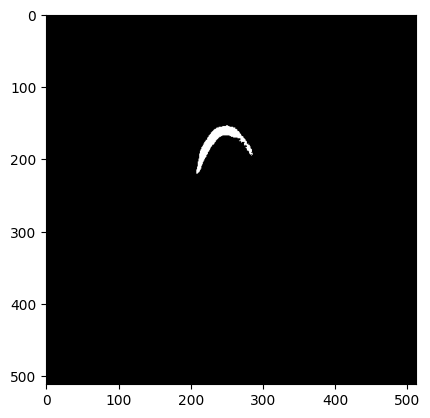

In [17]:
min_votes = 4
threshold_voted_structure = voted_structs >= min_votes
plt.imshow(threshold_voted_structure[selected_slice, :, :], cmap="gray")

## Simultaneous Truth and Performance Level Estimation (STAPLE)

The STAPLE procedure uses the **expectation-maximization algorithm** to iteratively estimate the quality of the individual segmentations. The final segmentation is then computed with these individual segmentation qualities taken into account by weighting the decisions made by a reliable segmentation algorithm higher than ones made by a less reliable algorithm.

SimpleITK makes the STAPLE procedure available under the name STAPLEImageFilter. We can use it to automate majority voting and achieve final segmentation.

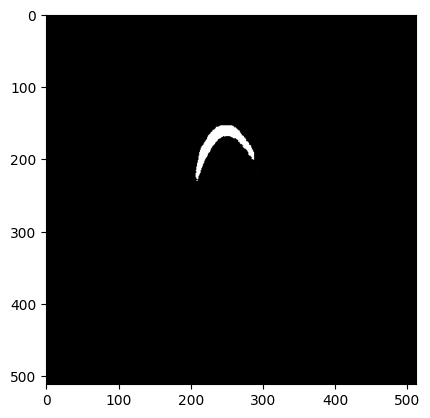

In [18]:
staple_procedure = sitk.STAPLEImageFilter()

# In input we must pass the deformed structures as SITK objects and not as arrays
staple_sitk_voted = staple_procedure.Execute(deformed_sitk_structs)

# Now we can convert the object obtained into an array with SITK and display the result
staple_voted = sitk.GetArrayFromImage(staple_sitk_voted)

plt.imshow(staple_voted[selected_slice, :, :], cmap="gray")

We can compare the two results obtained on the starting CT

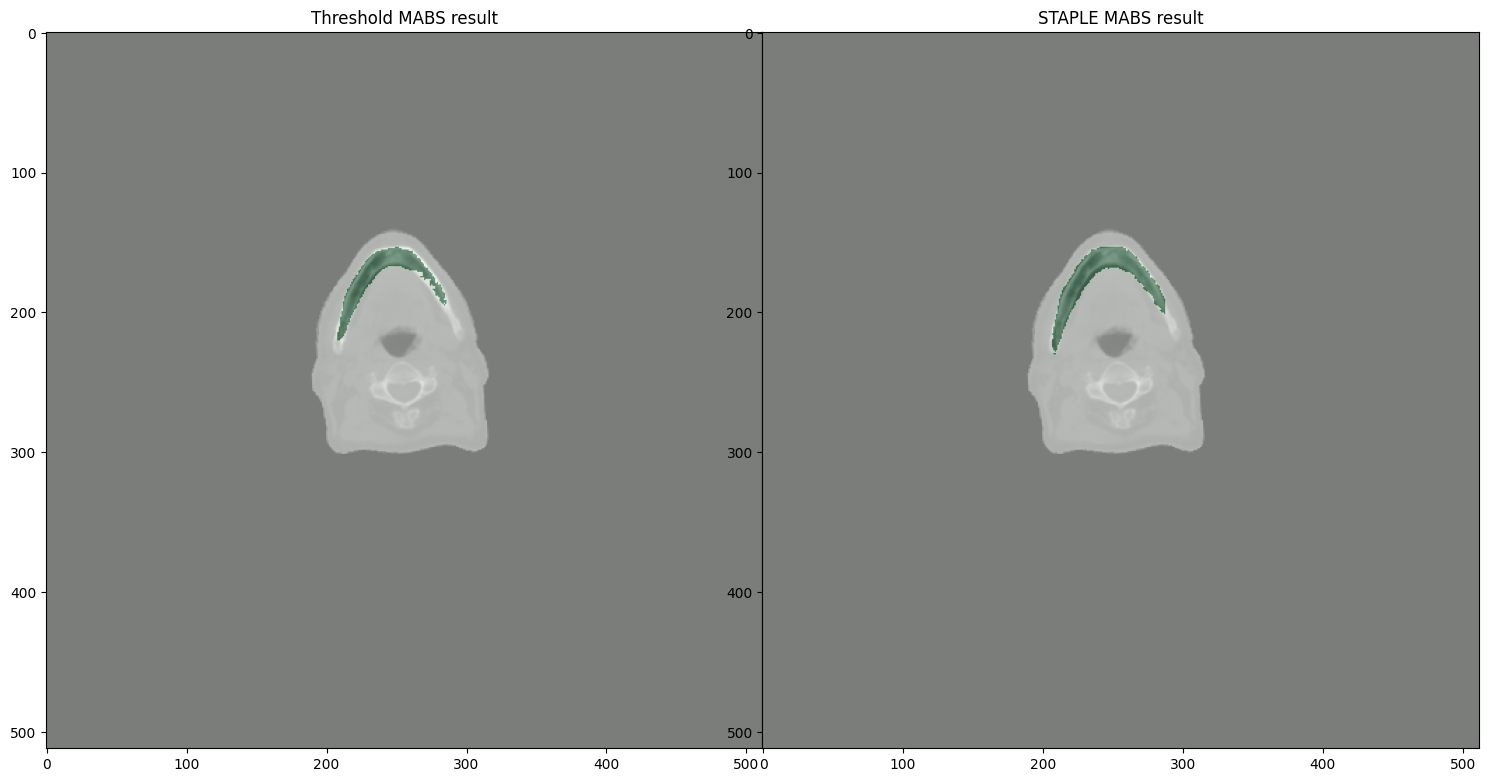

In [19]:
f, axarr = plt.subplots(1, 2, figsize=(15, 10))

img = axarr[0].imshow(ct[selected_slice, :, :], cmap="gray")
img = axarr[0].imshow(threshold_voted_structure.astype(
    int)[selected_slice, :, :], cmap="Greens", alpha=0.5)
axarr[0].set_title(f"Threshold MABS result")

img = axarr[1].imshow(ct[selected_slice, :, :], cmap="gray")
img = axarr[1].imshow(staple_voted[selected_slice, :, :],
                      cmap="Greens", alpha=0.5)
axarr[1].set_title(f"STAPLE MABS result")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

# Threshold vs. STAPLE: who is better?
We have therefore obtained two apparently very similar results, but which of these two best adapts to the patient's original structure?
We can find out thanks to the Jaccard (IoU) and Dice coefficients!

<center><img src="https://ilmonteux.github.io/assets/images/segmentation/metrics_iou_dice.png" /></center> 

We calculate the Dice between the segmentation obtained with the thresholding and the patient's structure.
SITK also makes this metric available, we just need to instantiate the LabelOverlapMeasuresImageFilter type overlapper and call the getDiceCoefficient method.

In [20]:
def dice(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 4)
    return dice

In [21]:
def jaccard(im1, im2):
    """
    Computes the Jaccard metric, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    jaccard : float
        Jaccard metric returned is a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0

    Notes
    -----
    The order of inputs for `jaccard` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1)
    im2 = np.asarray(im2)

    if im1.shape != im2.shape:
        raise ValueError(
            "Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    union = np.logical_or(im1, im2)

    return intersection.sum() / float(union.sum())

In [24]:

gt_sitk = sitk.ReadImage(r"C:\Users\User\Desktop\Master_Dersleri\Medical Image Processing for Navigation and Guidence\Data\MABS\patient\mandible.nrrd")
gt_array = sitk.GetArrayFromImage(gt_sitk)

bin_staple_voted = bin_img(staple_voted)
threshold_mabs_dice = dice(gt_array, threshold_voted_structure.astype(int))
staple_mabs_dice = dice(gt_array, bin_staple_voted)

print(
    f"Threshold MABS Dice coefficient: {threshold_mabs_dice}\nSTAPLE MABS Dice coefficient: {staple_mabs_dice}"
)


Threshold MABS Dice coefficient: 0.8038
STAPLE MABS Dice coefficient: 0.8205


In [25]:
threshold_mabs_iou = jaccard(gt_array, threshold_voted_structure.astype(int))
staple_mabs_iou = jaccard(gt_array, bin_staple_voted)

print(
    f"Threshold MABS Jaccard coefficient: {threshold_mabs_iou}\nSTAPLE MABS Jaccard coefficient: {staple_mabs_iou}")

Threshold MABS Jaccard coefficient: 0.6719208543853811
STAPLE MABS Jaccard coefficient: 0.6956920256645279


# Exercise 📚

Implement a method to determine the optimal number of votes needed to obtain the best results in multi-atlas segmentation, assessed by similarity metrics (Dice and Jaccard). Based on the results obtained for each structure and the time taken to run the algorithm, a total score will be calculated that equally weighs time and similarity performance.

In [ ]:
from typing import Tuple
import SimpleITK as sitk
import os
import numpy as np
from time import time

def dice(mask1, mask2):
    """Calculate Dice coefficient between two binary arrays."""
    intersect = np.sum(mask1 * mask2)
    return float((2 * intersect) / (np.sum(mask1) + np.sum(mask2)))

def jaccard(mask1, mask2):
    """Calculate Jaccard index between two binary arrays."""
    intersect = np.sum(mask1 * mask2)
    union = np.sum(mask1 + mask2 > 0)
    return float(intersect / union)

def get_best_threshold(gt_array, atlas_root, structure) -> Tuple[int, dict]:
    """
    Find the optimal number of votes to have the best result in terms of Dice and Jaccard.

    Args:
        gt_array (np.array): Ground truth segmentation
        atlas_root (str): Root directory of atlas segmentations
        structure (str): Structure to analyze

    Returns:
        optimal_votes (int): Optimal number of votes
        metrics (dict): Dictionary containing Dice, Jaccard, and runtime
    """
    
    atlas_segmentations = []
    for atlas_dir in os.listdir(atlas_root):
        if "atl" in atlas_dir:
            segmentation_path = os.path.join(atlas_root, atlas_dir, f"{structure}.nrrd")
            atlas_sitk = sitk.ReadImage(segmentation_path)
            atlas_array = sitk.GetArrayFromImage(atlas_sitk)
            atlas_segmentations.append(atlas_array)

    atlas_segmentations = np.array(atlas_segmentations)
    num_atlases = atlas_segmentations.shape[0]

    best_votes = 0
    best_metrics = {"Dice": 0.0, "Jaccard": 0.0}
    start_time = time()

    
    for votes in range(1, num_atlases + 1):
        
        thresholded = (np.sum(atlas_segmentations, axis=0) >= votes).astype(int)

        
        dice_score = dice(gt_array, thresholded)
        jaccard_score = jaccard(gt_array, thresholded)

        
        if (dice_score + jaccard_score) / 2 > (best_metrics["Dice"] + best_metrics["Jaccard"]) / 2:
            best_votes = votes
            best_metrics["Dice"] = dice_score
            best_metrics["Jaccard"] = jaccard_score

    runtime = time() - start_time
    best_metrics["Runtime"] = float(runtime)

    return best_votes, best_metrics


gt_path = r"C:\Users\User\Desktop\Master_Dersleri\Medical Image Processing for Navigation and Guidence\Data\MABS\patient\mandible.nrrd"
atlas_root = r"C:\Users\User\Desktop\Master_Dersleri\Medical Image Processing for Navigation and Guidence\Data\MABS"
structure = "mandible"


gt_array = sitk.GetArrayFromImage(sitk.ReadImage(gt_path))

optimal_votes, metrics = get_best_threshold(gt_array, atlas_root, structure)

print(f"Optimal Votes: {optimal_votes}")
print(f"Metrics: Dice: {metrics['Dice']:.4f}, Jaccard: {metrics['Jaccard']:.4f}, Runtime: {metrics['Runtime']:.2f} seconds")


Optimal Votes: 2
Metrics: Dice: 0.8189, Jaccard: 0.6934, Runtime: 6.21 seconds


In [ ]:
import SimpleITK as sitk
import os
import numpy as np
from time import time

def dice(mask1, mask2):
    intersect = np.sum(mask1 * mask2)
    return float((2 * intersect) / (np.sum(mask1) + np.sum(mask2)))

def jaccard(mask1, mask2):
    intersect = np.sum(mask1 * mask2)
    union = np.sum(mask1 + mask2 > 0)
    return float(intersect / union)

def get_best_threshold(gt_root, atlas_root, structures):
    best_votes = {}
    best_scores = {}

    for structure in structures:
        
        gt_path = os.path.join(gt_root, f"{structure}.nrrd")
        gt_array = sitk.GetArrayFromImage(sitk.ReadImage(gt_path))

        
        atlas_segmentations = []
        for atlas_dir in os.listdir(atlas_root):
            if "atl" in atlas_dir:
                segmentation_path = os.path.join(atlas_root, atlas_dir, f"{structure}.nrrd")
                atlas_sitk = sitk.ReadImage(segmentation_path)
                atlas_array = sitk.GetArrayFromImage(atlas_sitk)
                atlas_segmentations.append(atlas_array)

        atlas_segmentations = np.array(atlas_segmentations)
        num_atlases = atlas_segmentations.shape[0]

    
        best_vote = 0
        best_dice = 0
        best_jaccard = 0

        for votes in range(1, num_atlases + 1):
            thresholded = (np.sum(atlas_segmentations, axis=0) >= votes).astype(int)
            dice_score = dice(gt_array, thresholded)
            jaccard_score = jaccard(gt_array, thresholded)

            if (dice_score + jaccard_score) / 2 > (best_dice + best_jaccard) / 2:
                best_vote = votes
                best_dice = dice_score
                best_jaccard = jaccard_score

        best_votes[structure] = best_vote
        best_scores[structure] = {"dice": best_dice, "jaccard": best_jaccard}

    return best_votes, best_scores

def calculate_total_score(results, execution_time, max_time=10.0):
    sim_scores = [(res['dice'] + res['jaccard']) / 2 for key, res in results.items()]
    avg_sim_score = sum(sim_scores) / len(sim_scores)
    time_score = max(0, 1 - (execution_time / max_time))
    total_score = (avg_sim_score * 0.5) + (time_score * 0.5)
    return float(total_score * 100)


structures = ["mandible", "left_parotid", "right_parotid"]
selected_slice = 71

start_time = time()
gt_root = r"C:\Users\User\Desktop\Master_Dersleri\Medical Image Processing for Navigation and Guidence\Data\MABS\patient"
atlas_root = r"C:\Users\User\Desktop\Master_Dersleri\Medical Image Processing for Navigation and Guidence\Data\MABS"
best_votes, best_scores = get_best_threshold(gt_root, atlas_root, structures)
end_time = time()
execution_time = end_time - start_time

print("Atlas-Based Segmentation Metrics:")
for structure in structures:
    print(f"Structure: {structure}")
    print(f"  Optimal Threshold: {best_votes[structure]}")
    print(f"  Best Scores: Dice: {best_scores[structure]['dice']:.4f}, Jaccard: {best_scores[structure]['jaccard']:.4f}")

print(f"Execution Time: {execution_time:.2f} seconds")
print(f"Total Score: {calculate_total_score(best_scores, execution_time):.2f}")


Atlas-Based Segmentation Metrics:
Structure: mandible
  Optimal Threshold: 2
  Best Scores: Dice: 0.8189, Jaccard: 0.6934
Structure: left_parotid
  Optimal Threshold: 3
  Best Scores: Dice: 0.8488, Jaccard: 0.7373
Structure: right_parotid
  Optimal Threshold: 3
  Best Scores: Dice: 0.8253, Jaccard: 0.7025
Execution Time: 21.40 seconds
Total Score: 38.55


## References
[Wachinger C, Golland P. Atlas-based under-segmentation. Med Image Comput Comput Assist Interv. 2014;17(Pt 1):315-22. doi: 10.1007/978-3-319-10404-1_40. PMID: 25333133; PMCID: PMC4219918.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4219918/#:~:text=Atlas%2Dbased%20segmentation%20exploits%20knowledge,6%2C8%2C11%5D.)

[Mitchell, H.B. (2010). STAPLE: Simultaneous Truth and Performance Level Estimation. In: Image Fusion. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-11216-4_21](https://link.springer.com/chapter/10.1007/978-3-642-11216-4_21)

[Jaccard coefficient](https://gist.github.com/JDWarner/6730886)